In [1]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
from dataset.verse import VerseDataset
import hydra
from omegaconf import OmegaConf
import sys
from features_fusion.fusion import Fusion



In [2]:
if '.' not in sys.path:
    sys.path.append('.')

try:
    hydra.initialize(version_base=None, config_path="config")
except ValueError:
    pass 

cfg = hydra.compose(config_name="base_cfg", overrides=["model=ddpm"])


In [3]:
data_folder = cfg.dataset.folder

split_path = getattr(cfg.dataset, 'split_path', './splits.json')

if not os.path.exists(split_path):
    if os.path.exists('./splits.json'):
        split_path = './splits.json'
    else:
        raise FileNotFoundError(f"split not found : {split_path}")

with open(split_path, 'r') as f:
    splits = json.load(f)

train_files = splits['train']
print(len(train_files))

ds = VerseDataset(
    folder=data_folder,
    filenames=train_files,
)


212


In [4]:
patient_id = "verse005"


sample = ds[patient_id]
ct = sample['image']          
projs = sample['projections'] 
angles = sample['angles']     

real_name = sample.get('name', patient_id)
n_projs = len(angles)

print(f"Patient : {real_name}")
print(f"Total projections : {n_projs}")




Patient : verse005.pickle
Total projections : 5


In [5]:
print(projs.shape)

torch.Size([5, 1, 240, 240])


In [6]:
ct_zyx = ct[0].cpu().numpy()

ct_xyz = np.transpose(ct_zyx, (2, 1, 0))


ct_xyz_norm = (ct_xyz + 1) / 2

X, Y, Z = ct_xyz_norm.shape
cx, cy, cz = X//2, Y//2, Z//2



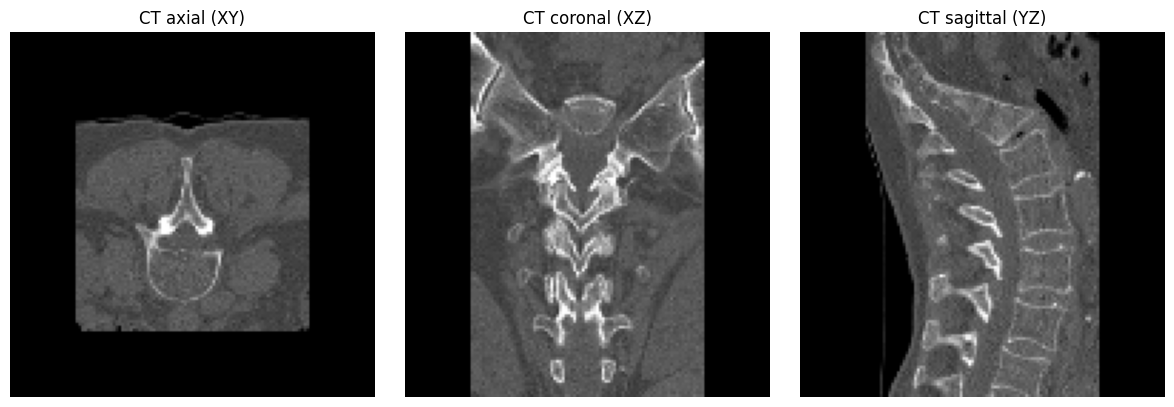

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))


ax[0].imshow(ct_xyz_norm[:, :, cz].T, cmap="gray")
ax[0].set_title("CT axial (XY)")
ax[0].axis("off")


ax[1].imshow(ct_xyz_norm[:, cy, :].T, cmap="gray")
ax[1].set_title("CT coronal (XZ)")
ax[1].axis("off")

ax[2].imshow(ct_xyz_norm[cx, :, :].T, cmap="gray")
ax[2].set_title("CT sagittal (YZ)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

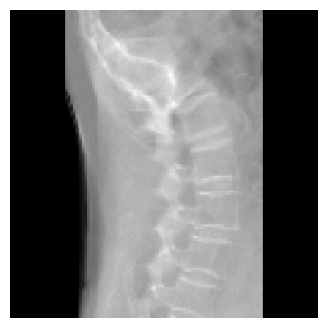

In [8]:
k=0
proj = projs[k, 0].cpu().numpy()

plt.figure(figsize=(4, 4))
plt.imshow(proj, cmap="gray")
plt.axis("off")
plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

t = 128
model = Fusion(
    volume_shape=(t, t, t), 
    vol_size_mm=(240.0, 240.0, 240.0), 
    det_size_mm=240.0,
    n_features=128
).to(device)


In [10]:
model.eval()

with torch.no_grad():
    output = model.forward_bypass(projs.cuda().unsqueeze(0), angles.cuda().unsqueeze(0))

print(output.shape)

torch.Size([1, 1, 128, 128, 128])


In [11]:
vol = output[0]
vol = vol.mean(dim=0)
vol = vol.detach().cpu().numpy()
print("vol 3D shape:", vol.shape)


vol 3D shape: (128, 128, 128)


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def to_xyz(vol3d, order):
    """
    order: "ZYX", "XYZ", "YXZ", "HWD"
    """
    order = order.upper()
    assert set(order) == set("XYZ"), f"order must be a permutation of 'XYZ', got {order}"

    # vol3d axes: (order[0], order[1], order[2]) -> want (X,Y,Z)
    idx = {ax:i for i,ax in enumerate(order)}
    return np.transpose(vol3d, (idx["X"], idx["Y"], idx["Z"]))

def show_fused_volume(vol3d, order="ZYX", title_prefix="Fused"):

    vol_xyz = to_xyz(vol3d, order)  # (X,Y,Z)

    X, Y, Z = vol_xyz.shape
    cx, cy, cz = X//2, Y//2, Z//2

    vmin = np.percentile(vol_xyz, 1)
    vmax = np.percentile(vol_xyz, 99)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(vol_xyz[:, :, cz].T, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
    ax[0].set_title(f"{title_prefix} axial (XY)")
    ax[0].axis("off")

    ax[1].imshow(vol_xyz[:, cy, :].T, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
    ax[1].set_title(f"{title_prefix} coronal (XZ)")
    ax[1].axis("off")

    ax[2].imshow(vol_xyz[cx, :, :].T, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
    ax[2].set_title(f"{title_prefix} sagittal (YZ)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


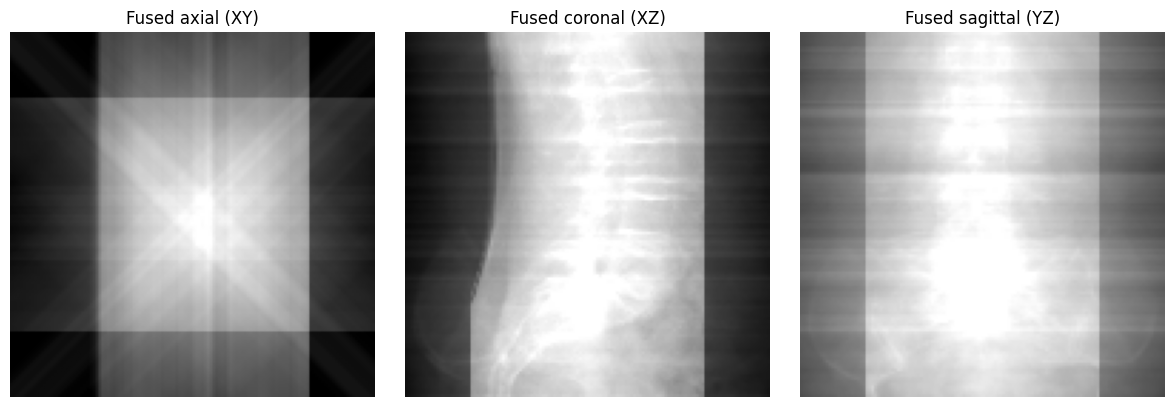

In [13]:
show_fused_volume(vol, order="ZYX")
